In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.5 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=757fb6de816f7b022d99af4852aad460f2b99330a260ddf9b043dc46d3a44ac9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=45b1366f0d3ec06cd877075ba0e5fde5454f549280421ff6a1efeff7cd547cdf
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 28.71 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
import sys
sys.path.append('/kaggle/working/Human-Segmentation-Dataset-master')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [6]:
CSV_FILE = '/kaggle/working/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/working/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

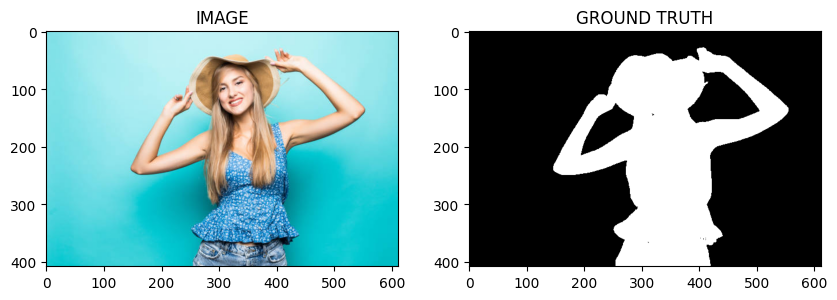

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),  # chance of flip
                    A.VerticalFlip(p=0.5)
  ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ],is_check_shapes=False)

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, index):
    row = self.df.iloc[index]
    
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # shape = (h, w)
    mask = np.expand_dims(mask, axis=-1)  # convert to shape = (h, w, c) w/ c=1

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask) # return as dictionary
      image = data.get('image')
      mask = data.get('mask')

    # shift (h, w, c) -> (c, h, w) since we use PyTorch
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # c:axis=2
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # convert to Tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)  # to 0 and 1 (we have 2 classes)

    return image, mask


In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


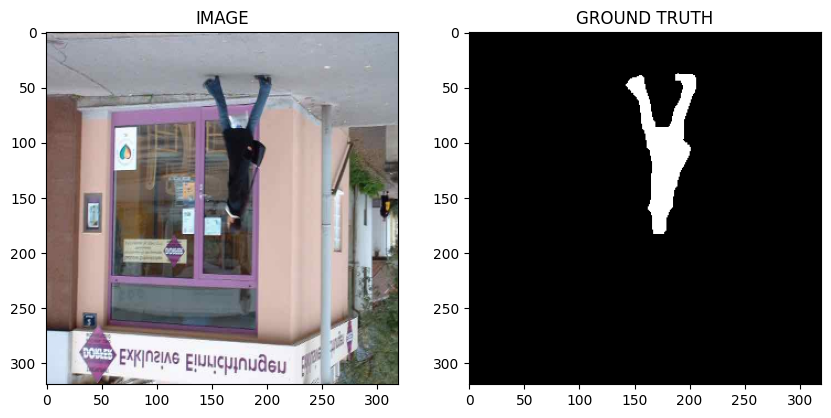

In [17]:
idx = 33

image, mask= trainset[idx]
helper.show_image(image, mask)

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [20]:
print(len(trainloader))

15


In [21]:
for image, mask in trainloader:
  print(image.shape)

torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([8, 3, 320, 320])


In [22]:
from torch import nn
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):
    def __init__ (self):
        super(SegmentationModel,self).__init__()

        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )
    

      
    
    def forward(self, images,masks = None ):
        logits = self.arc(images)
        
        if masks!= None:
            loss1 = DiceLoss(mode = 'binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            
            return logits, loss1 + loss2
        
        return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 250MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [25]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(data_loader)


In [26]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
    return total_loss / len(data_loader)

In [37]:
import torch
import numpy as np
from tqdm import tqdm

def train_fn(data_loader, model, optimizer, device = DEVICE):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, masks in tqdm(data_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute accuracy
        predicted_classes = torch.argmax(logits, dim=1)
        correct += (predicted_classes == masks).sum().item()
        total += masks.numel()

    accuracy = correct / total
    return total_loss / len(data_loader), accuracy

def eval_fn(data_loader, model, device = DEVICE):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)

            logits, loss = model(images, masks)

            total_loss += loss.item()

            # Compute accuracy
            predicted_classes = torch.argmax(logits, dim=1)
            correct += (predicted_classes == masks).sum().item()
            total += masks.numel()

    accuracy = correct / total
    return total_loss / len(data_loader), accuracy


In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [39]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader,model, optimizer)
    valid_loss = eval_fn(validloader, model)
    
    if valid_loss < best_valid_loss :
        torch.save(model.state_dict(), 'best_model.pt')
        print('Saved Model')
        
        best_valid_loss = valid_loss
        
    
    print(f"Epoch {i+1} : Train Loss {train_loss} , Valid Loss {valid_loss}")

 80%|████████  | 12/15 [00:04<00:01,  2.88it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Lists to store training and validation loss values
train_losses = []
valid_losses = []

best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    
    # Save the best model based on validation loss
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print('Saved Model')
        best_valid_loss = valid_loss
    
    # Print training and validation loss for each epoch
    print(f"Epoch {i+1} : Train Loss {train_loss:.4f} , Valid Loss {valid_loss:.4f}")
    
    # Append training and validation loss to respective lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

# Plotting the training and validation loss
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [40]:
import numpy as np

best_valid_loss = np.Inf

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_fn(trainloader, model, optimizer)
    valid_loss, valid_accuracy = eval_fn(validloader, model)
    
    if valid_loss < best_valid_loss :
        torch.save(model.state_dict(), 'best_model.pt')
        print('Saved Model')
        best_valid_loss = valid_loss
        
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Accuracy {train_accuracy:.4f}, Valid Loss {valid_loss:.4f}, Valid Accuracy {valid_accuracy:.4f}")


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Saved Model
Epoch 1: Train Loss 0.0940, Train Accuracy 11.1909, Valid Loss 0.2254, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch 2: Train Loss 0.1035, Train Accuracy 11.1793, Valid Loss 0.2567, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Epoch 3: Train Loss 0.0887, Train Accuracy 11.2020, Valid Loss 0.2417, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Epoch 4: Train Loss 0.0792, Train Accuracy 11.2003, Valid Loss 0.3140, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


Saved Model
Epoch 5: Train Loss 0.0797, Train Accuracy 11.1920, Valid Loss 0.2232, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Saved Model
Epoch 6: Train Loss 0.0886, Train Accuracy 11.1741, Valid Loss 0.1875, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Epoch 7: Train Loss 0.0975, Train Accuracy 11.1861, Valid Loss 0.3660, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 8: Train Loss 0.1024, Train Accuracy 11.2237, Valid Loss 0.2259, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch 9: Train Loss 0.0835, Train Accuracy 11.2168, Valid Loss 0.2471, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Saved Model
Epoch 10: Train Loss 0.0926, Train Accuracy 11.2156, Valid Loss 0.1571, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Saved Model
Epoch 11: Train Loss 0.0925, Train Accuracy 11.1756, Valid Loss 0.1562, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch 12: Train Loss 0.1239, Train Accuracy 11.2032, Valid Loss 0.2551, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch 13: Train Loss 0.1321, Train Accuracy 11.1799, Valid Loss 0.2878, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch 14: Train Loss 0.1169, Train Accuracy 11.1991, Valid Loss 0.1963, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 15: Train Loss 0.0915, Train Accuracy 11.1768, Valid Loss 0.1640, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch 16: Train Loss 0.0811, Train Accuracy 11.1752, Valid Loss 0.1640, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Epoch 17: Train Loss 0.0778, Train Accuracy 11.1853, Valid Loss 0.2059, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Epoch 18: Train Loss 0.0641, Train Accuracy 11.1827, Valid Loss 0.1620, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch 19: Train Loss 0.0608, Train Accuracy 11.1986, Valid Loss 0.1705, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch 20: Train Loss 0.0566, Train Accuracy 11.1878, Valid Loss 0.1719, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch 21: Train Loss 0.0670, Train Accuracy 11.2345, Valid Loss 0.1890, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Epoch 22: Train Loss 0.0758, Train Accuracy 11.1839, Valid Loss 0.2323, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


Epoch 23: Train Loss 0.0782, Train Accuracy 11.2016, Valid Loss 0.2489, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Epoch 24: Train Loss 0.0755, Train Accuracy 11.1819, Valid Loss 0.2006, Valid Accuracy 11.0691


100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

Epoch 25: Train Loss 0.0639, Train Accuracy 11.2070, Valid Loss 0.1832, Valid Accuracy 11.0691


In [41]:
idx = 5

model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze (0))  # (C, H, W) -> (1, C, H, W) where 1 is batch size just to use sigmoid
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

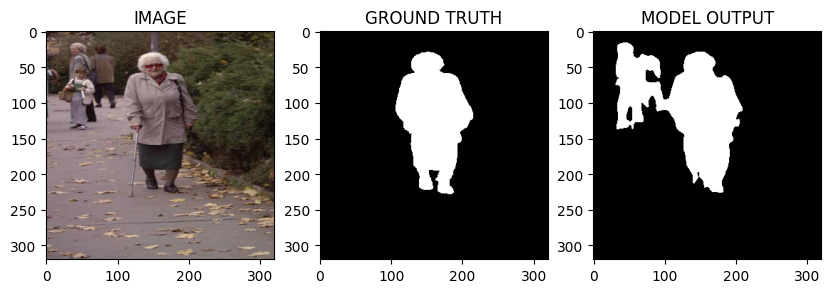

In [42]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) # convert back (1, C, H, W) -> (C, H, W)